In [1]:
import os
import json
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Metrics obtained from an organizer of the Challenge
# https://github.com/plamere/RecsysChallengeTools/blob/master/metrics.py
from metrics import r_precision
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
playlists = list()
tracks = dict()
map_pl = list()

max_files_for_quick_processing = 0


def process_track(track):
    key = track['track_uri']
    if not key in tracks:
        tk = dict()
        tk['track_artist_name'] = track['artist_name']
        tk['track_artist_uri'] = track['artist_uri']
        tk['track_name'] = track['track_name']
        tk['track_album_uri'] = track['album_uri']
        tk['track_duration_ms'] = track['duration_ms']
        tk['track_album_name'] = track['album_name']
        tracks[track['track_uri']] = tk
    return key


def process_playlist(playlist):
    pl = dict()
    pl['playlist_name'] = playlist['name']
    pl['playlist_collaborative'] = playlist['collaborative']
    pl['playlist_pid'] = playlist['pid']
    pl['playlist_modified_at'] = playlist['modified_at']
    pl['playlist_num_albums'] = playlist['num_albums']
    pl['playlist_num_tracks'] = playlist['num_tracks']
    pl['playlist_num_followers'] = playlist['num_followers']
    pl['playlist_num_edits'] = playlist['num_edits']
    pl['playlist_duration_ms'] = playlist['duration_ms']
    pl['playlist_num_artists'] = playlist['num_artists']
    if 'description' in playlist:
        pl['playlist_description'] = playlist['description']
    else:
        pl['playlist_description'] = ''
    trks = list()
    for track in playlist['tracks']:
        map_pl.append([playlist['pid'], track['track_uri']])
        trks.append(track['track_uri'])
        process_track(track)
    return pl

def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            slice = json.loads(js)
            for playlist in slice['playlists']:
                playlists.append(process_playlist(playlist))
            count += 1
            if quick and count > max_files_for_quick_processing:
                break

quick = True
process_mpd('mpd.v1/data')

mpd.slice.0-999.json


In [4]:
print(len(playlists))
print(len(tracks))
print(len(map_pl))

1000
34443
67503


In [5]:
playlist_df = pd.DataFrame(playlists)
playlist_df.head()
# print(playlist_df.describe())

,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid
0,false,,11532414,1493424000,Throwbacks,47,37,6,1,52,0
1,false,,11656470,1506556800,Awesome Playlist,23,21,5,1,39,1
2,false,,14039958,1505692800,korean,51,31,18,1,64,2
3,false,,28926058,1501027200,mat,107,86,4,1,126,3
4,false,,4335282,1401667200,90s,16,16,7,2,17,4


In [6]:
tracks_df = pd.DataFrame.from_dict(tracks, orient='index')
tracks_df.head()
# print(tracks_df.describe())

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name
spotify:track:000mA0etY38nKdvf1N04af,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way
spotify:track:000xQL6tZNLJzIrtIgxqSl,ZAYN,spotify:artist:5ZsFI1h6hIdQRw2ti0hz81,Still Got Time,spotify:album:2kGUeTGnkLOYlinKRJe47G,188490,Still Got Time
spotify:track:006AVH7fq061voGXkUiII4,Ryan O'Shaughnessy,spotify:artist:5xxkw4ElO0WX3v4i1W5kAQ,Fingertips,spotify:album:3MksslTJffj1jqxGkQt8Tm,191572,Fingertips
spotify:track:006PJvsr6CyV3JdBf7wiNF,Paul Wall,spotify:artist:0k7Xl1pqI3tu8sSEjo5oEg,Crumble the Satellite,spotify:album:0vUjMmaQwKyplM1cf5HQ8G,305320,slab god
spotify:track:006yrnQMCZpiUgkR612gC8,Desiigner,spotify:artist:7pFeBzX627ff0VnN6bxPR4,Caliber,spotify:album:0cHT4ll3sEPyFFWoFuibMl,123411,New English


In [7]:
playlist_map_df = pd.DataFrame(map_pl, columns=['playlist_pid', 'track_uri'])
playlist_map_df.head()
#print(playlist_map_df.describe())

,playlist_pid,track_uri
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
1,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak
2,0,spotify:track:0WqIKmW4BTrj3eJFmnCKMv
3,0,spotify:track:1AWQoqb9bSvzTjaLralEkT
4,0,spotify:track:1lzr43nnXAijIGYnCT8M8H


We set strings to lower case remove all non alphabetic characters and stop-words

In [8]:
import nltk
import string
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
ignored_words = [
    'music', 'songs', 'playlist', 'good', 'jams', 'mix', 'lit', 'best',
    'stuff', 'quot', 'like', 'one', 'amp', 'get', 'make', 'new', 'know',
    'really', 'back', 'day', 'days', 'little', 'things', 'great', 'everything',
    'jamz', 'tunes', 'artist', 'song', 'top', 'listen', 'favorite', 'bops',
    'description', 'top', 'ever', 'mostly', 'enjoy', 'bunch', 'track',
    'tracks', 'collection', 'need', 'every', 'favorites', 'may', 'got',
    'right', 'let', 'better', 'made'
]


def word_cleanup(df_col):
    df_col = df_col.apply(lambda x: x.lower())
    df_col = df_col.str.replace('[^a-z]+', ' ')
    df_col = df_col.apply(
        lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df_col = df_col.apply(lambda x: ' '.join([word for word in x.split() if word not in (ignored_words)]))
    df_col = df_col.str.replace(r'\b\w{1,2}\b', '').str.replace(r'\s+', ' ')
    return df_col


playlist_df.playlist_description = word_cleanup(
    playlist_df.playlist_description)
playlist_df.playlist_name = word_cleanup(playlist_df.playlist_name)

#playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: x.lower())
#playlist_df.playlist_name = playlist_df.playlist_name.str.replace('[^a-z]+', ' ')
#playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

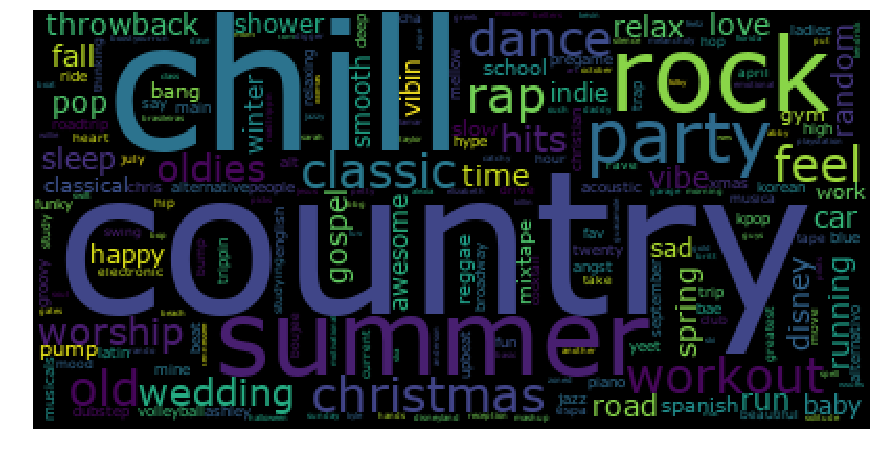

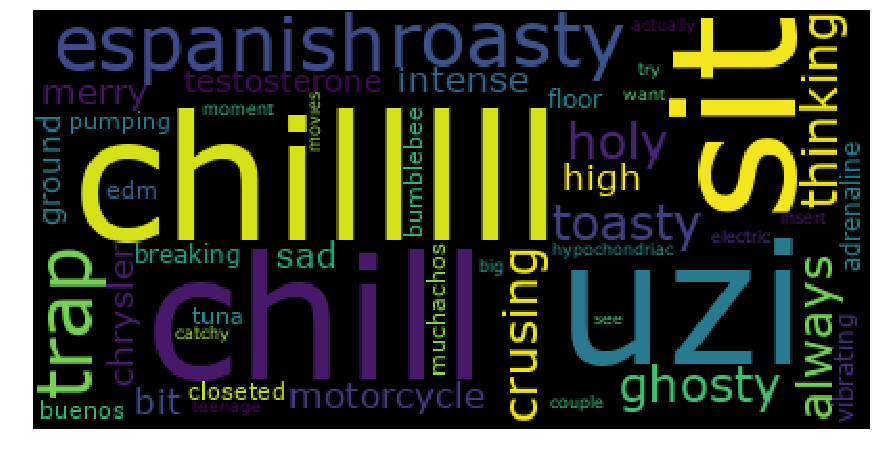

In [9]:
#pip install wordcloud
from wordcloud import WordCloud

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 0.1,
                          ).generate(text)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(' '.join(playlist_df.playlist_name))

generate_wordcloud(' '.join(playlist_df.playlist_description))

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv_description = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_description = cv_description.fit_transform(playlist_df.playlist_description)
playlist_df['playlist_description_frequency'] = list(dt_mat_description.toarray())

cv_name = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_name = cv_name.fit_transform(playlist_df.playlist_name)
playlist_df['playlist_name_frequency'] = list(dt_mat_name.toarray())

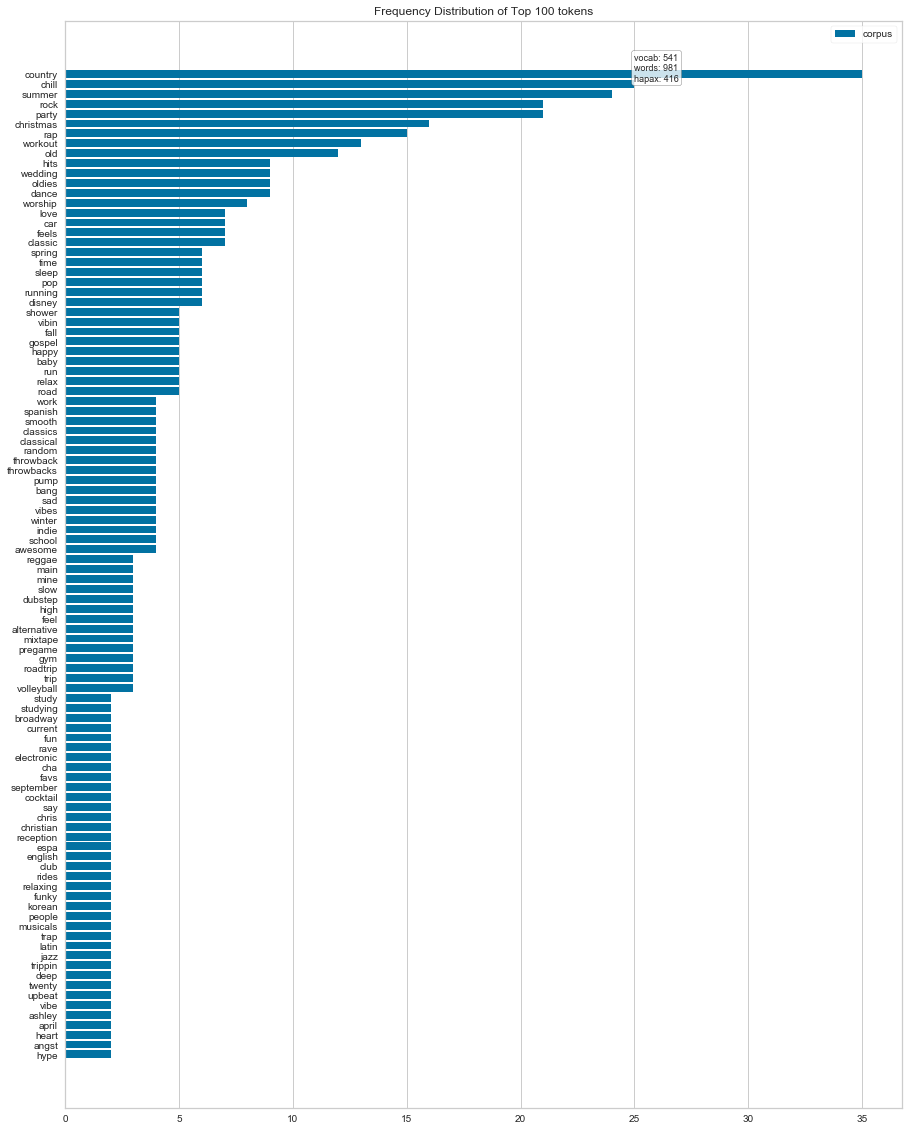

In [11]:
#pip install yellowbrick
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(15,20))
visualizer = FreqDistVisualizer(n=100, features = cv_name.get_feature_names())
visualizer.fit(dt_mat_name)
visualizer.poof()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

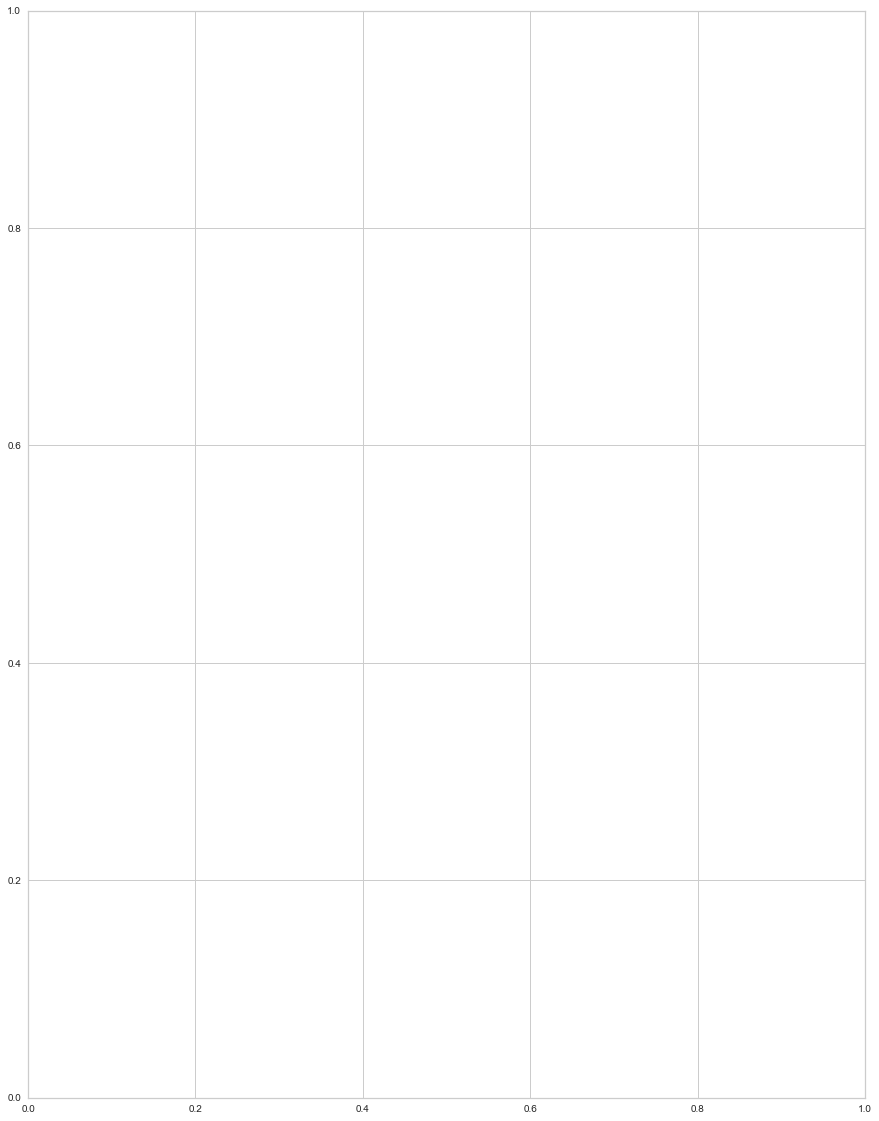

In [12]:
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(15,20))
visualizer = FreqDistVisualizer(n=100, features = cv_description.get_feature_names())
visualizer.fit(dt_mat_description)
visualizer.poof()

In [ ]:
tfidf_transformer = TfidfTransformer()

tfidf_mat_description = tfidf_transformer.fit_transform(dt_mat_description)
playlist_df['playlist_description_tfidf_score']=list(tfidf_mat_description.toarray())

tfidf_mat_name = tfidf_transformer.fit_transform(dt_mat_name)
playlist_df['playlist_name_tfidf_score']=list(tfidf_mat_name.toarray())
playlist_df

In [ ]:
bigrams_name_frequency = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_frequency['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_name_frequency)

bigrams_desc_frequency = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_frequency['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_desc_frequency)

bigrams_name_tfidf_score = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_name_tfidf_score)

bigrams_desc_tfidf_score = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_desc_tfidf_score)

In [13]:
merged = pd.merge(
    pd.merge(
        tracks_df, playlist_map_df, left_index=True, right_on='track_uri'),
    playlist_df,
    on='playlist_pid')

In [14]:
merged.head()

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,playlist_pid,track_uri,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_description_frequency,playlist_name_frequency
0,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way,371,spotify:track:000mA0etY38nKdvf1N04af,false,,3675883,1496793600,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Lewis Watson,spotify:artist:40ELTAg7Kg6vbWnlyx2n9R,stones around the sun,spotify:album:4cKBAg2zgjrVF2XefrW4WC,224440,the morning,371,spotify:track:0JGbwcwPV0VfuR4zDcZ9ce,false,,3675883,1496793600,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Jaymes Young,spotify:artist:6QrQ7OrISRYIfS5mtacaw2,We Won't,spotify:album:6MuWCR3WPjwyKhqsTKLZ3z,240586,Feel Something,371,spotify:track:0Zge2Kfo3Yd9JOGnAmVPbb,false,,3675883,1496793600,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,John Lucas,spotify:artist:7iEy8zKFtlYIINaxxLIyBk,This Will Be Our Home,spotify:album:2N7sEVVS3jKMJJuJi4v0UF,277160,Promised Land,371,spotify:track:1Sw7fhf7YJCD6GcWW0wETD,false,,3675883,1496793600,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Hozier,spotify:artist:2FXC3k01G6Gw61bmprjgqS,Cherry Wine - Live,spotify:album:36k5aXpxffjVGcNce12GLZ,240147,Hozier,371,spotify:track:1ivHxaGL5ld9VS1zsYc4YN,false,,3675883,1496793600,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
# Create Negative Samples
negative_samples = pd.DataFrame([])
for pid, df in tqdm(merged.groupby(["playlist_pid"])):
    negative_tracks = tracks_df.drop(df.track_uri).sample(df.shape[0])
    negative_playlist_tracks = pd.concat(
        [
            df.drop(list(tracks_df.columns) + ['track_uri'], axis=1).reset_index(
                drop=True), negative_tracks.reset_index()
        ],
        axis=1)
    negative_playlist_tracks.rename(columns={'index': 'track_uri'}, inplace=True)
    negative_samples = negative_samples.append(negative_playlist_tracks)


In [16]:
# Provide labels
negative_samples['match'] = 0
merged['match'] = 1

In [17]:
negative_samples.head()

,playlist_pid,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,...,playlist_description_frequency,playlist_name_frequency,track_uri,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,match
0,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",spotify:track:4Y5gx8VuShNmakYGlnrUzD,Natalie Taylor,spotify:artist:2WxjxdeF7GGdcCK276qViY,Surrender,spotify:album:02QDTrIeIhkXSYukXY6p0C,183103,Surrender,0
1,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",spotify:track:6El7EzBXlHmaC9bnhCtw9Y,Bloc Party,spotify:artist:3MM8mtgFzaEJsqbjZBSsHJ,This Modern Love,spotify:album:4KeTvCYCel3Ky58FirciWp,265560,Silent Alarm,0
2,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",spotify:track:7Erskuom3NxGlibr2c2wQa,Maxwell,spotify:artist:2AOt5htsbtyaHd5Eq3kl3j,Whenever Wherever Whatever - Live,spotify:album:5ejwNegV5hPkQRyMi7CiCs,285866,MTV Unplugged,0
3,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",spotify:track:7GPLE5ANcv6zhj628Jm94v,Coconut Records,spotify:artist:2YKp8Odp8GGbAkVU60Yk2Y,Wires,spotify:album:6G6DslmLUq5k4LpYZi5ZG1,155840,Davy,0
4,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",spotify:track:7IQWs82nSWONuLdFJ08y7Y,Chris Quilala,spotify:artist:45HXIkMqrQerbaPuw6FgKD,Won My Heart,spotify:album:2h5TkvxarUngpHvNadAERy,223480,Split The Sky,0


In [18]:
merged.head()

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,playlist_pid,track_uri,playlist_collaborative,playlist_description,...,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_description_frequency,playlist_name_frequency,match
0,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way,371,spotify:track:000mA0etY38nKdvf1N04af,false,,...,1496793600,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,Lewis Watson,spotify:artist:40ELTAg7Kg6vbWnlyx2n9R,stones around the sun,spotify:album:4cKBAg2zgjrVF2XefrW4WC,224440,the morning,371,spotify:track:0JGbwcwPV0VfuR4zDcZ9ce,false,,...,1496793600,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,Jaymes Young,spotify:artist:6QrQ7OrISRYIfS5mtacaw2,We Won't,spotify:album:6MuWCR3WPjwyKhqsTKLZ3z,240586,Feel Something,371,spotify:track:0Zge2Kfo3Yd9JOGnAmVPbb,false,,...,1496793600,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,John Lucas,spotify:artist:7iEy8zKFtlYIINaxxLIyBk,This Will Be Our Home,spotify:album:2N7sEVVS3jKMJJuJi4v0UF,277160,Promised Land,371,spotify:track:1Sw7fhf7YJCD6GcWW0wETD,false,,...,1496793600,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,Hozier,spotify:artist:2FXC3k01G6Gw61bmprjgqS,Cherry Wine - Live,spotify:album:36k5aXpxffjVGcNce12GLZ,240147,Hozier,371,spotify:track:1ivHxaGL5ld9VS1zsYc4YN,false,,...,1496793600,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [19]:
negative_samples.head()

,playlist_pid,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,...,playlist_description_frequency,playlist_name_frequency,track_uri,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,match
0,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",spotify:track:4Y5gx8VuShNmakYGlnrUzD,Natalie Taylor,spotify:artist:2WxjxdeF7GGdcCK276qViY,Surrender,spotify:album:02QDTrIeIhkXSYukXY6p0C,183103,Surrender,0
1,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",spotify:track:6El7EzBXlHmaC9bnhCtw9Y,Bloc Party,spotify:artist:3MM8mtgFzaEJsqbjZBSsHJ,This Modern Love,spotify:album:4KeTvCYCel3Ky58FirciWp,265560,Silent Alarm,0
2,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",spotify:track:7Erskuom3NxGlibr2c2wQa,Maxwell,spotify:artist:2AOt5htsbtyaHd5Eq3kl3j,Whenever Wherever Whatever - Live,spotify:album:5ejwNegV5hPkQRyMi7CiCs,285866,MTV Unplugged,0
3,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",spotify:track:7GPLE5ANcv6zhj628Jm94v,Coconut Records,spotify:artist:2YKp8Odp8GGbAkVU60Yk2Y,Wires,spotify:album:6G6DslmLUq5k4LpYZi5ZG1,155840,Davy,0
4,0,false,,11532414,1493424000,throwbacks,47,37,6,1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",spotify:track:7IQWs82nSWONuLdFJ08y7Y,Chris Quilala,spotify:artist:45HXIkMqrQerbaPuw6FgKD,Won My Heart,spotify:album:2h5TkvxarUngpHvNadAERy,223480,Split The Sky,0


In [20]:
merged.columns

Index(['track_artist_name', 'track_artist_uri', 'track_name',
       'track_album_uri', 'track_duration_ms', 'track_album_name',
       'playlist_pid', 'track_uri', 'playlist_collaborative',
       'playlist_description', 'playlist_duration_ms', 'playlist_modified_at',
       'playlist_name', 'playlist_num_albums', 'playlist_num_artists',
       'playlist_num_edits', 'playlist_num_followers', 'playlist_num_tracks',
       'playlist_description_frequency', 'playlist_name_frequency', 'match'],
      dtype='object')

In [21]:
negative_samples.columns

Index(['playlist_pid', 'playlist_collaborative', 'playlist_description',
       'playlist_duration_ms', 'playlist_modified_at', 'playlist_name',
       'playlist_num_albums', 'playlist_num_artists', 'playlist_num_edits',
       'playlist_num_followers', 'playlist_num_tracks',
       'playlist_description_frequency', 'playlist_name_frequency',
       'track_uri', 'track_artist_name', 'track_artist_uri', 'track_name',
       'track_album_uri', 'track_duration_ms', 'track_album_name', 'match'],
      dtype='object')

In [22]:
dataset = merged.append(negative_samples[merged.columns]).sort_values(by=['playlist_pid']).reset_index(drop=True)

In [23]:
dataset.head()

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,playlist_pid,track_uri,playlist_collaborative,playlist_description,...,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_description_frequency,playlist_name_frequency,match
0,Kylie Minogue,spotify:artist:4RVnAU35WRWra6OZ3CbbMA,Can't Get You Out Of My Head,spotify:album:6FTq1YhYJLetfJQrq02gdv,230640,Fever,0,spotify:track:7m2g1kKuF7Tre2PzjK3Lnh,false,,...,1493424000,throwbacks,47,37,6,1,52,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,Chairlift,spotify:artist:7hAolICGSgXJuM6DUpK5rp,Bruises,spotify:album:3JuIBAoHi6gUmS3tgF4CPg,241466,Does You Inspire You,0,spotify:track:4mdyVTV7Tr5YDFnD2kvSM4,false,,...,1493424000,throwbacks,47,37,6,1,52,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,The Notorious B.I.G.,spotify:artist:5me0Irg2ANcsgc93uaYrpb,Big Poppa - Instrumental,spotify:album:53eZ4hJLZaxoM81SEkS2jv,253271,Big Poppa,0,spotify:track:4BEDarNN0POSKYLsUnD3Ee,false,,...,1493424000,throwbacks,47,37,6,1,52,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,The Pussycat Dolls,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,Beep,spotify:album:0ylxpXE00fVxh6d60tevT8,229360,PCD,0,spotify:track:2jFlMILIQzs7lSFudG9lbo,false,,...,1493424000,throwbacks,47,37,6,1,52,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,Ne-Yo,spotify:artist:21E3waRsmPlU7jZsS13rcj,Closer,spotify:album:1nv3KEXZPmcwOXMoLTs1vn,234360,Year Of The Gentleman,0,spotify:track:2nbClS09zsIAqNkshg6jnp,false,,...,1493424000,throwbacks,47,37,6,1,52,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [95]:
data_y = dataset.match

In [102]:
# Include the features in the list below
features = [
    'playlist_duration_ms', 'playlist_num_albums', 'playlist_num_artists',
    'playlist_num_edits', 'playlist_num_followers', 'playlist_num_tracks',
    'playlist_pid', 'track_duration_ms'
]
# data_x = dataset[features]
data_x = dataset.loc[:, dataset.columns != 'match']
data_y = dataset.match
data_train, data_test, y_train, y_test = train_test_split(
    data_x,
    data_y,
    test_size=0.1,
    stratify=dataset.playlist_pid,
    random_state=42,
    shuffle=True)

In [103]:
data_test.shape

(13501, 20)

In [105]:
data_train.shape

(121505, 20)

In [106]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        # from IPython.core.debugger import set_trace; set_trace()
        return data_dict[:,[self.key]].astype(np.int64)

In [188]:
# %%time

# we need a custom pre-processor to extract correct field,
# but want to also use default scikit-learn preprocessing (e.g. lowercasing)
default_preprocessor = CountVectorizer().build_preprocessor()


def build_preprocessor(field):
    field_idx = list(merged.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])


vectorizer = FeatureUnion([
    (
        'track_artist_uri',
        CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r".+",
            stop_words=None,
            # max_features=50000,
            preprocessor=build_preprocessor('track_artist_uri'))),
    (
        'track_album_uri',
        CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r".+",
            stop_words=None,
            # max_features=50000,
            preprocessor=build_preprocessor('track_album_uri'))),
    (
        'track_uri',
        CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r".+",
            stop_words=None,
            # max_features=50000,
            preprocessor=build_preprocessor('track_uri'))),
    ('track_duration_ms',
     ItemSelector(list(merged.columns).index('track_duration_ms'))),
    ('playlist_pid',
     ItemSelector(list(merged.columns).index('playlist_pid'))),
    
#playlist info
    
    ("playlist_name",
      CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r"(?u)\b\w+\b",
            stop_words=None,
            analyzer = 'word',
            # max_features=50000,
            preprocessor=build_preprocessor("playlist_name"))),
    
    ("playlist_description",
      CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r"(?u)\b\w+\b",
            stop_words=None,
            analyzer = 'word',
            # max_features=50000,
            preprocessor=build_preprocessor("playlist_description"))),

])

X_train = vectorizer.fit_transform(data_train.values)
X_test = vectorizer.transform(data_test.values)

In [183]:
#explore vectorizer data matrix
vectorizer.get_feature_names().index('playlist_name__times')

63273

In [185]:
X_train[: ,63273].toarray()

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [189]:
#try randomforest tree on data
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth = 100).fit(X_train, y_train)
prediction = model.predict(X_train)
1 - np.mean(abs(prediction - y_train))

0.6294144273898193

In [191]:
#test prediction
prediction = model.predict(X_test)
1 - np.mean(abs(prediction - y_test))

0.58203096066958

The dataset has been split, which is great. However, in order to better simulate real world situations, we need to build a test set with a lot more negative samples than there are positive samples. In the split above, there are equal number of positive and negative samples, so it'll be easy for the algorithm to perform. Below we build a more robust test set

In [ ]:
X_train.columns

In [ ]:
X_test_refined.head()

In [ ]:
y_test.head()
# y_test[y_test == 1].head()

In [ ]:
dataset.loc[X_test.head().index]

In [ ]:
# 1. Calculate metric only on test set using the positive samples
#     a. Obtain unique playlists in the test set
#     b. For each playlist, obtain the positve songs.
#     c. Set both `target` and `prediction` as lists of the positive songs
#     d. For each playlist, calculate the r_precision. r_precision comes from the metrics.py file in the repo.

# 2. Train the X_train on the classifier. Obtain predictions for X_test

# 3. Repeat 1 above, now setting `predictions` as the list of songs "ranked by probability".

# 4. Calculate the r_precision metric based on your predicitons!

In [ ]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    probs = y_test.loc[df.index]  # change y_test to the output probs from clf
    targets = dataset.loc[probs[probs == 1].index].track_uri
    predictions = dataset.loc[probs[probs > 0.5].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

In [ ]:
X_train_norm = (X_train-X_train.mean())/X_train.std()
X_test_norm = (X_test-X_test.mean())/X_test.std()

In [ ]:
X_train_norm.head()

In [ ]:
X_test_norm.head()

In [ ]:
lr_clf = LogisticRegression()
lr_clf = lr_clf.fit(X_train_norm, y_train)

In [ ]:
# y_prob = lr_clf.predict_proba(X_test)
y_prob = pd.DataFrame(lr_clf.predict_proba(X_test_norm), index=y_test.index)

In [ ]:
y_prob.head(10)

In [ ]:
y_test.head(10)

In [ ]:
y_pred = y_prob.idxmax(axis=1)

In [ ]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    labels = y_test.loc[df.index]  # change y_test to the output probs from clf
    preds = y_pred.loc[df.index]
    targets = dataset.loc[labels[labels == 1].index].track_uri
    predictions = dataset.loc[preds[preds == 1].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

In [ ]:
X_test_refined = pd.DataFrame([])
r_precisions = []
pbar = tqdm(data_test.groupby(['playlist_pid']))
for pid, df in pbar:
    labels = y_test.loc[df.index]
    targets = dataset.loc[labels.index].track_duration_ms
    positive_targets = dataset.loc[labels[labels == 1].index].index
    # trained_idx = set(y_train[y_train == 1].index) - set(df.index)
    # Obtain all tracks from dataset which are not in the playlist under consideration
    #     negative_tracks = dataset.loc[X_train[(X_train.playlist_pid != pid)]
    #                                   .index].track_duration_ms
    negative_tracks = dataset.loc[X_test[(X_test.playlist_pid != pid)]
                                  .index].track_duration_ms
    # trained_tracks = X_train.loc[y_train.loc[y_train[y_train==1].index].index].track_uri
    new_df = df.drop('track_duration_ms', axis=1)
    new_test = negative_tracks.append(targets)
    new_df = pd.concat([new_df.head(1)] * len(new_test))
    test_playlist_tracks = pd.concat(
        [new_df.reset_index(drop=True), new_test.reset_index(drop=True)],
        axis=1).set_index(new_test.index)
    # from IPython.core.debugger import set_trace; set_trace()
    test_playlist_tracks = (test_playlist_tracks-test_playlist_tracks.mean())/(test_playlist_tracks.std()+1e-8)
    X_test_refined = X_test_refined.append(test_playlist_tracks)
    y_prob = pd.DataFrame(
        lr_clf.predict_proba(test_playlist_tracks),
        index=test_playlist_tracks.index)
    y_prob = y_prob.sort_values(by=[1], ascending=False)
    if len(positive_targets) > 0:
        r_precisions.append(r_precision(positive_targets, y_prob.index))
    pbar.set_description("{}".format(np.mean(r_precisions)))
    # from IPython.core.debugger import set_trace; set_trace()

In [ ]:
np.unique(r_precisions, return_counts=True)

In [ ]:
np.mean(r_precisions)

Question: Do playlist and track duration interact to influence whether a song should belong to a playlist `(match=1)` or whether a song should not belong to a playlist `(match=0)`?

In [ ]:
(dataset[dataset.match==1].playlist_duration_ms/dataset[dataset.match==1].playlist_num_tracks)

In [ ]:
plt.scatter(dataset[dataset.match == 1].playlist_duration_ms /
            dataset[dataset.match == 1].playlist_num_tracks,
            dataset[dataset.match == 1].track_duration_ms)
plt.scatter(dataset[dataset.match == 0].playlist_duration_ms /
            dataset[dataset.match == 0].playlist_num_tracks,
            dataset[dataset.match == 0].track_duration_ms)
plt.xlabel('Average Track Duration')
plt.ylabel('Track Duration')


A trend which might not be that strong to notice is that as the average track duration increases for a playlist, the propensity to see a track of long duration increases. However, this isn't the case with negative sample playlists, where in playlist of short length very long tracks can still be detected.

In [ ]:
plt.hist(dataset[dataset.match==1].playlist_duration_ms)
plt.hist(dataset[dataset.match==0].playlist_duration_ms)